|| Feature Selection using Particle Selection Optimization ||

In [1]:
import numpy as np
import joblib
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets

from sklearn.svm import SVC

# from Py_FS.wrapper.nature_inspired._utilities import Solution, Data, initialize, sort_agents, display, compute_fitness, Conv_plot
# from Py_FS.wrapper.nature_inspired._transfer_functions import get_trans_function


##### There was two feature selector that been inputted, uncomment one of them to make it run 

In [2]:
#import dataset
X_train = pd.read_csv('dataset-after-preparation/X_train.csv')
X_test = pd.read_csv('dataset-after-preparation/X_test.csv')
y_train = pd.read_csv('dataset-after-preparation/y_train.csv')
y_test = pd.read_csv('dataset-after-preparation/y_test.csv')

#import feature (by using Select KBest and Variance Threshold)
sel_feat = joblib.load("sel_feat.pkl")
X_train = X_train[sel_feat]

#import feature and dataset (by using Variance Threshold Only)
# sel_feat = joblib.load("sel_feat_VTOnly.pkl")
# X_train = X_train[sel_feat]

In [3]:
class Solution():    
    #structure of the solution 
    def __init__(self):
        self.num_features = None
        self.num_agents = None
        self.max_iter = None
        self.obj_function = None
        self.execution_time = None
        self.convergence_curve = {}
        self.best_agent = None
        self.best_fitness = None
        self.best_accuracy = None
        self.final_population = None
        self.final_fitness = None
        self.final_accuracy = None


class Data():
    # structure of the training data
    def __init__(self):
        self.train_X = None
        self.train_Y = None
        self.val_X = None
        self.val_Y = None
        
def compute_fitness(agent, train_X, test_X, train_Y, test_Y, weight_acc=0.9):
    # compute a basic fitness measure
    if(weight_acc == None):
        weight_acc = 0.9

    weight_feat = 1 - weight_acc
    num_features = agent.shape[0]
    
    acc = compute_accuracy(agent, train_X, test_X, train_Y, test_Y)
    feat = (num_features - np.sum(agent))/num_features

    fitness = weight_acc * acc + weight_feat * feat
    return fitness


def Conv_plot(convergence_curve):
    # plot convergence curves
    num_iter = len(convergence_curve['fitness'])
    iters = np.arange(num_iter) + 1
    fig, axes = plt.subplots(1)
    fig.tight_layout(pad = 5) 
    fig.suptitle('Convergence Curves')
    
    axes.set_title('Convergence of Fitness over Iterations')
    axes.set_xlabel('Iteration')
    axes.set_ylabel('Avg. Fitness')
    axes.plot(iters, convergence_curve['fitness'])

    return fig, axes


def get_trans_function(shape):
    if (shape.lower() == 's'):
        return sigmoid

    elif (shape.lower() == 'v'):
        return v_func

    elif(shape.lower() == 'u'):
        return u_func

    else:
        print('\n[Error!] We don\'t currently support {}-shaped transfer functions...\n'.format(shape))
        exit(1)
        

def sigmoid(val):
    if val < 0:
        return 1 - 1/(1 + np.exp(val))
    else:
        return 1/(1 + np.exp(-val))


def initialize(num_agents, num_features):
    # define min and max number of features
    min_features = int(0.3 * num_features)
    max_features = int(0.6 * num_features)

    # initialize the agents with zeros
    agents = np.zeros((num_agents, num_features))

    # select random features for each agent
    for agent_no in range(num_agents):

        # find random indices
        cur_count = np.random.randint(min_features, max_features)
        temp_vec = np.random.rand(1, num_features)
        temp_idx = np.argsort(temp_vec)[0][0:cur_count]

        # select the features with the ranom indices
        agents[agent_no][temp_idx] = 1   

    return agents

def sort_agents(agents, obj, data, fitness=None):
    # sort the agents according to fitness
    train_X, val_X, train_Y, val_Y = data.train_X, data.val_X, data.train_Y, data.val_Y
    (obj_function, weight_acc) = obj
   
    if fitness is None:
        # if there is only one agent
        if len(agents.shape) == 1:
            num_agents = 1
            fitness = obj_function(agents, train_X, val_X, train_Y, val_Y, weight_acc)
            return agents, fitness

        # for multiple agents
        else:
            num_agents = agents.shape[0]
            fitness = np.zeros(num_agents)
            for id, agent in enumerate(agents):
                fitness[id] = obj_function(agent, train_X, val_X, train_Y, val_Y, weight_acc)

    idx = np.argsort(-fitness)
    sorted_agents = agents[idx].copy()
    sorted_fitness = fitness[idx].copy()

    return sorted_agents, sorted_fitness

def compute_accuracy(agent, train_X, test_X, train_Y, test_Y): 
    # compute classification accuracy of the given agents
    cols = np.flatnonzero(agent)     
    if(cols.shape[0] == 0):
        return 0    
    clf = SVC(kernel='linear')
    train_data = train_X[:,cols]
    train_label = train_Y
    test_data = test_X[:,cols]
    test_label = test_Y

    clf.fit(train_data,train_label)
    acc = clf.score(test_data,test_label)

    return acc


In [4]:
def PSO(num_agents, max_iter, weight_acc, train_data, train_label, obj_function=compute_fitness, trans_func_shape='s', save_conv_graph=False):
    
    # Particle Swarm Optimizer
    ############################### Parameters ####################################
    #                                                                             #
    #   num_agents: number of particles                                           #
    #   max_iter: maximum number of generations                                   #
    #   train_data: training samples of data                                      #
    #   train_label: class labels for the training samples                        #                
    #   obj_function: the function to maximize while doing feature selection      #
    #   trans_function_shape: shape of the transfer function used                 #
    #   save_conv_graph: boolean value for saving convergence graph               #
    #                                                                             #
    ###############################################################################
    
    short_name = 'PSO'
    agent_name = 'Particle'
    train_data, train_label = np.array(train_data), np.array(train_label)
    num_features = train_data.shape[1]
    trans_function = get_trans_function(trans_func_shape)
    
    # setting up the objectives
    weight_acc = None
    if(obj_function==compute_fitness):
        # weight_acc = float(input('Weight for the classification accuracy [0-1]: '))
        weight_acc = weight_acc 
    obj = (obj_function, weight_acc)
    compute_accuracy = (compute_fitness, 1) # compute_accuracy is just compute_fitness with accuracy weight as 1

    # initialize particles and Leader (the agent with the max fitness)
    particles = initialize(num_agents, num_features)
    fitness = np.zeros(num_agents)
    accuracy = np.zeros(num_agents)
    Leader_agent = np.zeros((1, num_features))
    Leader_fitness = float("-inf")
    Leader_accuracy = float("-inf")

    # initialize convergence curves
    convergence_curve = {}
    convergence_curve['fitness'] = np.zeros(max_iter)

    # initialize data class
    
    data = Data()
    val_size = 0.3
    # val_size = float(input('Enter the percentage of data wanted for valdiation [0, 100]: '))/100
    data.train_X, data.val_X, data.train_Y, data.val_Y = train_test_split(train_data, train_label, stratify=train_label, test_size=val_size)
    

    # create a solution object
    solution = Solution()
    solution.num_agents = num_agents
    solution.max_iter = max_iter
    solution.num_features = num_features
    solution.obj_function = obj_function

    # rank initial particles
    particles, fitness = sort_agents(particles, obj, data)

    # start timer
    start_time = time.time()

    # initialize global and local best particles
    globalBestParticle = [0 for i in range(num_features)]
    globalBestFitness = float("-inf")
    localBestParticle = [ [ 0 for i in range(num_features) ] for j in range(num_agents) ] 
    localBestFitness = [float("-inf") for i in range(num_agents) ]
    weight = 1.0 
    velocity = [ [ 0.0 for i in range(num_features) ] for j in range(num_agents) ]
    
    for iter_no in range(max_iter):
        print('\n================================================================================')
        print('                          Iteration - {}'.format(iter_no+1))
        print('================================================================================\n')
        
        # update weight
        weight = 1.0 - (iter_no / max_iter)
        
        # update the velocity
        for i in range(num_agents):
            for j in range(num_features):
                velocity[i][j] = (weight*velocity[i][j])
                r1, r2 = np.random.random(2)
                velocity[i][j] = velocity[i][j] + (r1 * (localBestParticle[i][j] - particles[i][j]))
                velocity[i][j] = velocity[i][j] + (r2 * (globalBestParticle[j] - particles[i][j]))
       
        # updating position of particles
        for i in range(num_agents):
            for j in range(num_features):
                trans_value = trans_function(velocity[i][j])
                if (np.random.random() < trans_value): 
                    particles[i][j] = 1
                else:
                    particles[i][j] = 0
                 
        # updating fitness of particles
        particles, fitness = sort_agents(particles, obj, data)
        display(particles, fitness, agent_name)
        
        
        # updating the global best and local best particles
        for i in range(num_agents):
            if fitness[i]>localBestFitness[i]:
                localBestFitness[i]=fitness[i]
                localBestParticle[i]=particles[i][:]

            if fitness[i]>globalBestFitness:
                globalBestFitness=fitness[i]
                globalBestParticle=particles[i][:]

        # update Leader (best agent)
        if globalBestFitness > Leader_fitness:
            Leader_agent = globalBestParticle.copy()
            Leader_fitness = globalBestFitness.copy()

        convergence_curve['fitness'][iter_no] = np.mean(fitness)

    # compute final accuracy
    Leader_agent, Leader_accuracy = sort_agents(Leader_agent, compute_accuracy, data)
    particles, accuracy = sort_agents(particles, compute_accuracy, data)

    print('\n================================================================================')
    print('                                    Final Result                                  ')
    print('================================================================================\n')
    print('Leader ' + agent_name + ' Dimension : {}'.format(int(np.sum(Leader_agent))))
    print('Leader ' + agent_name + ' Fitness : {}'.format(Leader_fitness))
    print('Leader ' + agent_name + ' Classification Accuracy : {}'.format(Leader_accuracy))
    print('\n================================================================================\n')

    # stop timer
    end_time = time.time()
    exec_time = end_time - start_time

    # plot convergence graph
    fig, axes = Conv_plot(convergence_curve)
    # if(save_conv_graph):
    #     plt.savefig('convergence_graph_'+ short_name + '.jpg')
    plt.show()

    # update attributes of solution
    solution.best_agent = Leader_agent
    solution.best_fitness = Leader_fitness
    solution.best_accuracy = Leader_accuracy
    solution.convergence_curve = convergence_curve
    solution.final_particles = particles
    solution.final_fitness = fitness
    solution.final_accuracy = accuracy
    solution.execution_time = exec_time

    return solution


# if __name__ == '__main__': 
    
#     # data = datasets.load_digits()
#     PSO(20, 100, 0.8, X_train, y_train, save_conv_graph=True)


                          Iteration - 1



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

array([0.73766946, 0.73354734, 0.70583521, 0.70524004, 0.70489836,
       0.70462282, 0.7042591 , 0.70375211, 0.70338839, 0.7033443 ,
       0.70044559, 0.70002677, 0.69994962, 0.67231464, 0.67060627,
       0.6701654 , 0.66889791, 0.64126293, 0.64125191, 0.63535529])

'Particle'


                          Iteration - 2



array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

array([0.73910228, 0.73609335, 0.73565249, 0.73398821, 0.73222473,
       0.73216962, 0.70634221, 0.70500858, 0.70466691, 0.7041048 ,
       0.70368598, 0.70328919, 0.70196659, 0.69989451, 0.67319638,
       0.67302003, 0.67207216, 0.67207216, 0.6693498 , 0.66771858])

'Particle'


                          Iteration - 3



array([[0., 1., 1., ..., 0., 1., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

array([0.73813237, 0.73534388, 0.73495812, 0.73425273, 0.73397719,
       0.73194919, 0.70526208, 0.70519595, 0.70483223, 0.70413787,
       0.70040151, 0.6728547 , 0.67272244, 0.67256814, 0.6716864 ,
       0.67022051, 0.66749815, 0.64165971, 0.63858465, 0.63639133])

'Particle'


                          Iteration - 4



array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 1.]])

array([0.73736085, 0.73528877, 0.73406536, 0.70494245, 0.70213191,
       0.70209885, 0.67338374, 0.67278857, 0.67114634, 0.67024256,
       0.66820354, 0.66804924, 0.6668148 , 0.6659    , 0.63973091,
       0.63915778, 0.63751555, 0.63610477, 0.63329423, 0.60572539])

'Particle'


                          Iteration - 5



array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

array([0.73663342, 0.73581781, 0.7319051 , 0.73188306, 0.73060454,
       0.72957952, 0.70355372, 0.70210987, 0.70087544, 0.70069909,
       0.69899073, 0.69799877, 0.69797673, 0.69655493, 0.67197297,
       0.67042993, 0.67006621, 0.668435  , 0.63863976, 0.63721796])

'Particle'


                          Iteration - 6



array([[0., 1., 0., ..., 0., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

array([0.73542103, 0.73505731, 0.73330486, 0.73247823, 0.73056045,
       0.72967872, 0.72938113, 0.70078727, 0.69921116, 0.69851679,
       0.67050708, 0.67045197, 0.67002212, 0.66946001, 0.66886484,
       0.6681815 , 0.66799413, 0.66745406, 0.63365795, 0.63095763])

'Particle'


                          Iteration - 7



array([[0., 1., 0., ..., 0., 1., 1.],
       [1., 1., 0., ..., 0., 1., 1.],
       [0., 1., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 1.]])

array([0.76728834, 0.76211916, 0.73427477, 0.73298523, 0.73254436,
       0.73245619, 0.73068169, 0.72923785, 0.7022752 , 0.70108485,
       0.70026924, 0.69888051, 0.69874825, 0.6987262 , 0.69743666,
       0.66897506, 0.66817047, 0.6643239 , 0.63613783, 0.63072617])

'Particle'


                          Iteration - 8



array([[0., 1., 1., ..., 0., 1., 1.],
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [1., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.]])

array([0.73542103, 0.73279786, 0.73279786, 0.72957952, 0.70174615,
       0.70173513, 0.70101872, 0.70002677, 0.69980633, 0.69827431,
       0.69741462, 0.69732645, 0.69677536, 0.66860032, 0.66821456,
       0.66764143, 0.66714546, 0.66711239, 0.63363591, 0.63060493])

'Particle'


                          Iteration - 9



array([[0., 1., 1., ..., 0., 1., 1.],
       [0., 1., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 1., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 1., 0.]])

array([0.76545874, 0.73537694, 0.73025185, 0.72996528, 0.72994324,
       0.72853246, 0.72811363, 0.70129426, 0.69960794, 0.69950875,
       0.69939853, 0.69802082, 0.69712806, 0.66977964, 0.66851215,
       0.66772961, 0.66588898, 0.66518359, 0.66452229, 0.62916109])

'Particle'


                          Iteration - 10



array([[0., 1., 1., ..., 0., 1., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 1., 1., 0.]])

array([0.76763002, 0.75936373, 0.73123278, 0.73078089, 0.73056045,
       0.70072113, 0.69944262, 0.69737053, 0.69669821, 0.6959818 ,
       0.66875463, 0.66836887, 0.66811537, 0.666914  , 0.66500724,
       0.66478681, 0.66367362, 0.63276519, 0.63137645, 0.59591606])

'Particle'


                          Iteration - 11



array([[0., 0., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 1.],
       [1., 0., 1., ..., 1., 1., 0.]])

array([0.76352994, 0.76039977, 0.73477075, 0.73170671, 0.72881902,
       0.72730905, 0.70119507, 0.70076522, 0.70067705, 0.6993324 ,
       0.69925525, 0.69679741, 0.6676745 , 0.66628576, 0.66541505,
       0.66535994, 0.66515053, 0.66454433, 0.66414755, 0.66056549])

'Particle'


                          Iteration - 12



array([[0., 1., 1., ..., 0., 1., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 0., 0., ..., 1., 0., 0.]])

array([0.73588394, 0.73086906, 0.73072578, 0.73019674, 0.72791524,
       0.70045661, 0.69738156, 0.66845704, 0.66612044, 0.66610941,
       0.66506235, 0.66461046, 0.66361851, 0.66355238, 0.66333194,
       0.66310049, 0.66246123, 0.63573003, 0.63363591, 0.62743068])

'Particle'


                          Iteration - 13



array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 1., 0.]])

array([0.7314973 , 0.73125482, 0.7294142 , 0.72836713, 0.70272709,
       0.69978429, 0.69875927, 0.69834044, 0.69734849, 0.69605895,
       0.69556297, 0.69473634, 0.69439467, 0.66593307, 0.66485294,
       0.66336501, 0.66291312, 0.65832808, 0.63402167, 0.60001614])

'Particle'


                          Iteration - 14



array([[0., 1., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 1.]])

array([0.73482586, 0.7309903 , 0.72692329, 0.72599747, 0.69920014,
       0.69896868, 0.69586056, 0.69556297, 0.69516619, 0.66641802,
       0.66572365, 0.66553629, 0.66368464, 0.66327683, 0.66231794,
       0.65892326, 0.63501362, 0.63321708, 0.6320598 , 0.62994363])

'Particle'


                          Iteration - 15



array([[1., 0., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 1., 1.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

array([0.76310009, 0.73511242, 0.73031798, 0.7299763 , 0.72987711,
       0.72701146, 0.69778936, 0.69759097, 0.69469226, 0.69467021,
       0.69410811, 0.6649852 , 0.66415857, 0.66337603, 0.66210853,
       0.6343964 , 0.63268804, 0.63120011, 0.63024122, 0.62560108])

'Particle'


                          Iteration - 16



array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 1., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 1.]])

array([0.76181055, 0.73462747, 0.73011959, 0.72961259, 0.72932602,
       0.72680205, 0.72573294, 0.69807592, 0.69764608, 0.69670923,
       0.69451591, 0.69449387, 0.69449387, 0.66673765, 0.66208649,
       0.66165664, 0.658284  , 0.63442947, 0.631652  , 0.59882579])

'Particle'


                          Iteration - 17



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 0., 0.]])

array([0.76250492, 0.76079655, 0.7345944 , 0.73049432, 0.73041717,
       0.72896231, 0.69881438, 0.69673127, 0.69521028, 0.69501189,
       0.69456   , 0.69426241, 0.66516155, 0.66445616, 0.66373975,
       0.66325479, 0.6627037 , 0.6580305 , 0.629624  , 0.62948072])

'Particle'


                          Iteration - 18



array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 1., 1.]])

array([0.76231755, 0.73423068, 0.73082498, 0.73064863, 0.72831202,
       0.72660366, 0.72618483, 0.69914503, 0.69707295, 0.69386563,
       0.69378848, 0.66617554, 0.66445616, 0.66423572, 0.66325479,
       0.66232897, 0.65783211, 0.62969013, 0.62877533, 0.62853285])

'Particle'


                          Iteration - 19



array([[0., 1., 1., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 1., 1., ..., 0., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 0.]])

array([0.73356938, 0.73034002, 0.7296677 , 0.69835147, 0.69773425,
       0.69697375, 0.69633449, 0.69612508, 0.69475839, 0.69345783,
       0.69162822, 0.69017336, 0.66618657, 0.66398222, 0.66303436,
       0.66092921, 0.63116704, 0.62899576, 0.59738195, 0.59690802])

'Particle'


                          Iteration - 20



array([[0., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [1., 0., 1., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 1., 0.]])

array([0.76531546, 0.76237266, 0.72605257, 0.69847271, 0.69795469,
       0.69616917, 0.69390972, 0.6934468 , 0.69297287, 0.66632985,
       0.6654922 , 0.66464353, 0.66332092, 0.66154643, 0.66144723,
       0.65911063, 0.63289745, 0.63045063, 0.62955787, 0.62650486])

'Particle'


                          Iteration - 21



array([[0., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 0., 1., ..., 1., 1., 0.]])

array([0.76146888, 0.75800806, 0.70061092, 0.69868212, 0.69805388,
       0.69798775, 0.69782242, 0.69677536, 0.69611406, 0.69406402,
       0.66558037, 0.66207547, 0.66131497, 0.66123782, 0.65972784,
       0.65758963, 0.63006487, 0.62881942, 0.59954221, 0.5983739 ])

'Particle'


                          Iteration - 22



array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 1., 1.]])

array([0.72967872, 0.72857655, 0.72725394, 0.72615177, 0.69784447,
       0.69771221, 0.69657697, 0.69451591, 0.69367826, 0.66850113,
       0.66522768, 0.66501826, 0.66362953, 0.6629021 , 0.66269268,
       0.66055447, 0.62879737, 0.62771725, 0.62600888, 0.59634591])

'Particle'


                          Iteration - 23



array([[0., 1., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.]])

array([0.73197123, 0.7304833 , 0.72845531, 0.72809159, 0.69685251,
       0.69632347, 0.69465919, 0.69460408, 0.69376643, 0.69317126,
       0.69268631, 0.66532687, 0.66507337, 0.66450024, 0.66205342,
       0.66183299, 0.6612268 , 0.65840524, 0.62868716, 0.62723229])

'Particle'


                          Iteration - 24



array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 1.]])

array([0.76431248, 0.73064863, 0.72862063, 0.72587623, 0.69812001,
       0.69666514, 0.69554093, 0.69346885, 0.66559139, 0.66502929,
       0.66368464, 0.66210853, 0.66177788, 0.66150234, 0.65947434,
       0.65789824, 0.63286439, 0.62977831, 0.62903985, 0.62873124])

'Particle'


                          Iteration - 25



array([[1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 1., 1.]])

array([0.73207043, 0.72869778, 0.72726496, 0.72627301, 0.69802082,
       0.69766812, 0.6963896 , 0.69544173, 0.69519926, 0.69378848,
       0.69338067, 0.69224544, 0.66572365, 0.66504031, 0.66390507,
       0.63042859, 0.63021917, 0.62917211, 0.62557903, 0.59338107])

'Particle'


                          Iteration - 26



array([[1., 0., 0., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 0., 1., ..., 0., 1., 0.]])

array([0.76022343, 0.73182795, 0.72979996, 0.7277389 , 0.72761766,
       0.69709499, 0.69654391, 0.69376643, 0.69345783, 0.66671561,
       0.6651395 , 0.66233999, 0.66210853, 0.66171175, 0.66114964,
       0.66060958, 0.65882406, 0.65715978, 0.63187243, 0.62980035])

'Particle'


                          Iteration - 27



array([[0., 0., 0., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 1., 0.]])

array([0.72957952, 0.72565579, 0.69954181, 0.69836249, 0.69720521,
       0.69702886, 0.69641165, 0.69621325, 0.69560706, 0.6937003 ,
       0.69334761, 0.6642247 , 0.66216364, 0.66165664, 0.66114964,
       0.66108351, 0.66088512, 0.65771087, 0.6576227 , 0.63040654])

'Particle'


                          Iteration - 28



array([[0., 1., 1., ..., 0., 1., 1.],
       [0., 1., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 1., 1.],
       [0., 1., 0., ..., 0., 1., 1.]])

array([0.73051637, 0.72981098, 0.72903946, 0.72756255, 0.69835147,
       0.6963896 , 0.69426241, 0.66365157, 0.6631556 , 0.66237305,
       0.66159051, 0.66142519, 0.66127088, 0.6603671 , 0.65820685,
       0.63259986, 0.63108989, 0.62994363, 0.62660405, 0.56505172])

'Particle'


                          Iteration - 29



array([[0., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 1., 1., 0.]])

array([0.72784911, 0.72765072, 0.72714372, 0.72658162, 0.69849475,
       0.69815308, 0.69789958, 0.6967423 , 0.69539765, 0.66435696,
       0.66340909, 0.66322173, 0.66209751, 0.66124884, 0.66074184,
       0.63025224, 0.62895168, 0.62829037, 0.62617421, 0.62530349])

'Particle'


                          Iteration - 30



array([[1., 1., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 0., 0.]])

array([0.72749642, 0.69886949, 0.69866007, 0.69722725, 0.6963896 ,
       0.69606997, 0.69594873, 0.69580545, 0.69452693, 0.69382154,
       0.69292878, 0.69262018, 0.6632107 , 0.66185503, 0.66117169,
       0.6606206 , 0.65801948, 0.63067106, 0.62998772, 0.62574436])

'Particle'


                          Iteration - 31



array([[0., 1., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 1., 1.]])

array([0.7311446 , 0.72886311, 0.72657059, 0.69683047, 0.69595976,
       0.69549684, 0.69534254, 0.69469226, 0.69460408, 0.69273039,
       0.68999701, 0.66612044, 0.66408142, 0.66220773, 0.66134803,
       0.66123782, 0.66013565, 0.65999236, 0.65797539, 0.63064902])

'Particle'


                          Iteration - 32



array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 1., ..., 1., 0., 0.],
       [1., 1., 0., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 0.]])

array([0.76150194, 0.73039513, 0.729315  , 0.72877494, 0.72681307,
       0.72657059, 0.69558502, 0.6954748 , 0.69528743, 0.69514415,
       0.69322637, 0.69308309, 0.69015131, 0.66307844, 0.66154643,
       0.66088512, 0.66010258, 0.63402167, 0.62894066, 0.62608603])

'Particle'


                          Iteration - 33



array([[0., 1., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 0., 0.]])

array([0.73161854, 0.7272319 , 0.69673127, 0.69662106, 0.69610304,
       0.69564013, 0.6956291 , 0.69474737, 0.69297287, 0.69081262,
       0.66281392, 0.6627037 , 0.6627037 , 0.6627037 , 0.66171175,
       0.66156847, 0.66146927, 0.6612819 , 0.65826195, 0.62935948])

'Particle'


                          Iteration - 34



array([[0., 1., 1., ..., 0., 1., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 1., 0.]])

array([0.76231755, 0.73086906, 0.72758459, 0.72643833, 0.72501653,
       0.69629041, 0.69620223, 0.69545276, 0.6953756 , 0.69461511,
       0.69406402, 0.69392074, 0.66293516, 0.66275881, 0.66127088,
       0.66091819, 0.6608741 , 0.63255578, 0.6266812 , 0.62574436])

'Particle'


                          Iteration - 35



array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 0., 0.]])

array([0.75840484, 0.72486223, 0.6974036 , 0.69614712, 0.69592669,
       0.69541969, 0.69469226, 0.69398687, 0.69387665, 0.69298389,
       0.68983168, 0.66653926, 0.66373975, 0.66343114, 0.66325479,
       0.6623951 , 0.66194321, 0.66157949, 0.65835013, 0.63111193])

'Particle'


                          Iteration - 36



array([[0., 1., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 1., 1.]])

array([0.75836076, 0.73040615, 0.69691864, 0.69586056, 0.69582749,
       0.69505597, 0.69467021, 0.69463715, 0.69374439, 0.69366724,
       0.69365622, 0.69365622, 0.69359009, 0.66307844, 0.65941923,
       0.65873589, 0.63344854, 0.63135441, 0.63009794, 0.62940357])

'Particle'


                          Iteration - 37



array([[0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 1., 1.],
       [1., 1., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 0., 1., 1.]])

array([0.76003606, 0.75884571, 0.7291607 , 0.72826794, 0.72700044,
       0.72700044, 0.72690125, 0.69495678, 0.69381052, 0.66444514,
       0.66286903, 0.66249429, 0.66235101, 0.66111658, 0.65959558,
       0.63159689, 0.62980035, 0.62932642, 0.62559006, 0.59708436])

'Particle'


                          Iteration - 38



array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 0., 1.]])

array([0.72939215, 0.7271327 , 0.72590929, 0.69604793, 0.69558502,
       0.69530947, 0.6949678 , 0.69493474, 0.69487963, 0.69441672,
       0.69367826, 0.693546  , 0.66345318, 0.66337603, 0.66258247,
       0.66166766, 0.65885713, 0.65839422, 0.62980035, 0.62977831])

'Particle'


                          Iteration - 39



array([[0., 1., 0., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 0., 1.],
       [1., 0., 1., ..., 1., 1., 0.]])

array([0.76027853, 0.75778763, 0.72604155, 0.69698477, 0.695574  ,
       0.69535356, 0.6951221 , 0.69503393, 0.69390972, 0.69330352,
       0.66359646, 0.66291312, 0.66285801, 0.66238408, 0.66194321,
       0.66175584, 0.66171175, 0.6590445 , 0.62857694, 0.62682449])

'Particle'


                          Iteration - 40



array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 1., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 0.]])

array([0.75908819, 0.75747902, 0.72811363, 0.6964888 , 0.69569523,
       0.6954748 , 0.69530947, 0.69500087, 0.69489065, 0.69416322,
       0.69127553, 0.66362953, 0.6621416 , 0.66130395, 0.66094023,
       0.66084104, 0.6594523 , 0.63105682, 0.629117  , 0.59770158])

'Particle'


                          Iteration - 41



array([[1., 1., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.]])

array([0.75804113, 0.72832305, 0.72747437, 0.72726496, 0.72716577,
       0.72550149, 0.69618019, 0.69478043, 0.69397585, 0.69394278,
       0.69316024, 0.66299027, 0.66248327, 0.66074184, 0.65918778,
       0.65881304, 0.63031837, 0.6299767 , 0.62889657, 0.59795508])

'Particle'


                          Iteration - 42



array([[1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 1.],
       [1., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 1., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.]])

array([0.72793729, 0.72788218, 0.72774992, 0.72695635, 0.69579443,
       0.69484656, 0.69463715, 0.69459306, 0.69444978, 0.66342012,
       0.6632107 , 0.66228488, 0.66213058, 0.66146927, 0.66139212,
       0.66094023, 0.65871384, 0.6307372 , 0.62854387, 0.62762907])

'Particle'


                          Iteration - 43



array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 1., 1.]])

array([0.72924887, 0.72757357, 0.72657059, 0.7257109 , 0.69558502,
       0.69538663, 0.69456   , 0.69409709, 0.69393176, 0.69378848,
       0.69352396, 0.69245485, 0.69183763, 0.69117633, 0.66313355,
       0.66231794, 0.66216364, 0.66113862, 0.63154178, 0.63075924])

'Particle'


                          Iteration - 44



array([[1., 1., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [1., 1., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

array([0.72835611, 0.7277389 , 0.72732007, 0.72704453, 0.72639425,
       0.72491734, 0.69625734, 0.69568421, 0.69550786, 0.69544173,
       0.69518824, 0.6942073 , 0.6912094 , 0.66329888, 0.66285801,
       0.66135906, 0.66118271, 0.6312993 , 0.62978933, 0.62771725])

'Particle'


                          Iteration - 45



array([[1., 0., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 1., 1., 1.]])

array([0.75866936, 0.72812466, 0.72762868, 0.72640527, 0.72535821,
       0.69579443, 0.69515517, 0.69432854, 0.69414117, 0.66404835,
       0.66350829, 0.66278086, 0.66173379, 0.66171175, 0.63075924,
       0.63027428, 0.62966809, 0.62899576, 0.62695675, 0.62694573])

'Particle'


                          Iteration - 46



array([[1., 1., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

array([0.75926454, 0.72717679, 0.7269784 , 0.7263722 , 0.72582112,
       0.69567319, 0.69470328, 0.69451591, 0.69417424, 0.69406402,
       0.69345783, 0.66304538, 0.66273677, 0.66220773, 0.66207547,
       0.66101738, 0.65889019, 0.65882406, 0.6303845 , 0.63020815])

'Particle'


                          Iteration - 47



array([[1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.]])

array([0.72544638, 0.69545276, 0.69543071, 0.69541969, 0.69513313,
       0.69473634, 0.69320433, 0.69115429, 0.69114327, 0.66312253,
       0.66304538, 0.66297925, 0.66228488, 0.66227386, 0.66215262,
       0.66203138, 0.66078593, 0.62991057, 0.62988852, 0.59881477])

'Particle'


                          Iteration - 48



array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 1., 0.]])

array([0.72809159, 0.72689022, 0.7258652 , 0.72579907, 0.69533152,
       0.69505597, 0.69457102, 0.69448285, 0.6943065 , 0.69429548,
       0.69419628, 0.69410811, 0.69374439, 0.69265324, 0.66354136,
       0.66271473, 0.66197627, 0.66156847, 0.66148029, 0.65890121])

'Particle'


                          Iteration - 49



array([[0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

array([0.72828998, 0.72778298, 0.72642731, 0.72639425, 0.69545276,
       0.695067  , 0.69357907, 0.69322637, 0.6931382 , 0.691518  ,
       0.69072444, 0.66296823, 0.66293516, 0.6628029 , 0.66242816,
       0.66232897, 0.66157949, 0.66076388, 0.6299767 , 0.62928233])

'Particle'


                          Iteration - 50



array([[1., 0., 1., ..., 0., 1., 0.],
       [1., 1., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 1., 1., 0.]])

array([0.72866472, 0.72690125, 0.72582112, 0.7250496 , 0.69555195,
       0.69525437, 0.69503393, 0.69485758, 0.69435058, 0.69428445,
       0.694053  , 0.69375541, 0.66291312, 0.66286903, 0.6626486 ,
       0.66259349, 0.66175584, 0.6611276 , 0.65886815, 0.59625773])

'Particle'


                          Iteration - 51



array([[1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       ...,
       [1., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.]])

array([0.72583214, 0.72554557, 0.69480248, 0.69393176, 0.69373337,
       0.69368928, 0.69128655, 0.69123144, 0.66401529, 0.66368464,
       0.66301231, 0.66300129, 0.66297925, 0.66253838, 0.66224079,
       0.6617889 , 0.66171175, 0.62984444, 0.62938152, 0.5982196 ])

'Particle'


                          Iteration - 52



array([[1., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 1., 0.]])

array([0.75934169, 0.72626199, 0.72614075, 0.7244434 , 0.69584954,
       0.69535356, 0.6949678 , 0.69454898, 0.69427343, 0.69383256,
       0.69367826, 0.69357907, 0.69191479, 0.66285801, 0.66247225,
       0.66241714, 0.66196525, 0.66161256, 0.66070877, 0.62954685])

'Particle'


                          Iteration - 53



array([[1., 0., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [1., 1., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.]])

array([0.72792626, 0.72746335, 0.72616279, 0.72582112, 0.72567784,
       0.72557864, 0.72551251, 0.69528743, 0.69479145, 0.69458204,
       0.69452693, 0.69368928, 0.69249894, 0.6638169 , 0.66296823,
       0.6629572 , 0.66181095, 0.66172277, 0.66121577, 0.65982704])

'Particle'


                          Iteration - 54



array([[0., 1., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 0., 1., ..., 1., 1., 0.]])

array([0.72727598, 0.7258652 , 0.69513313, 0.69400891, 0.69378848,
       0.69371133, 0.66323275, 0.66308946, 0.66289107, 0.66253838,
       0.66127088, 0.66099534, 0.6598601 , 0.65977193, 0.6313985 ,
       0.63066004, 0.63041757, 0.63032939, 0.62984444, 0.62955787])

'Particle'


                          Iteration - 55



array([[1., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 1.],
       [1., 0., 1., ..., 1., 0., 1.]])

array([0.72642731, 0.7244434 , 0.69502291, 0.69495678, 0.6948135 ,
       0.69450489, 0.69444978, 0.69442774, 0.66241714, 0.66238408,
       0.66236203, 0.66219671, 0.66206445, 0.66185503, 0.66176686,
       0.66172277, 0.6607198 , 0.62991057, 0.62966809, 0.62849979])

'Particle'


                          Iteration - 56



array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.]])

array([0.72709964, 0.72705555, 0.72691227, 0.7264714 , 0.7262179 ,
       0.72604155, 0.72552353, 0.69523232, 0.69517721, 0.69454898,
       0.69440569, 0.69428445, 0.69404198, 0.69353498, 0.69333659,
       0.69268631, 0.69140779, 0.66259349, 0.66210853, 0.65971682])

'Particle'


                          Iteration - 57



array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

array([0.72691227, 0.72568886, 0.69556297, 0.69467021, 0.69456   ,
       0.69414117, 0.69399789, 0.69386563, 0.69374439, 0.69361213,
       0.69170537, 0.6630564 , 0.66206445, 0.66198729, 0.66118271,
       0.66065367, 0.66063162, 0.62977831, 0.62956889, 0.62745272])

'Particle'


                          Iteration - 58



array([[0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

array([0.72833407, 0.72676898, 0.72550149, 0.72410173, 0.6948135 ,
       0.69476941, 0.69470328, 0.69438365, 0.69393176, 0.69368928,
       0.69331454, 0.69300594, 0.69287368, 0.69269733, 0.6638169 ,
       0.66191014, 0.66154643, 0.6606206 , 0.66037812, 0.62901781])

'Particle'


                          Iteration - 59



array([[0., 1., 1., ..., 0., 1., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 0., 1.],
       [1., 1., 0., ..., 0., 0., 0.]])

array([0.72629505, 0.7255566 , 0.72542434, 0.695574  , 0.69526539,
       0.6951221 , 0.69503393, 0.69458204, 0.69425139, 0.69388767,
       0.66294618, 0.6629021 , 0.66216364, 0.6617889 , 0.66168971,
       0.66110556, 0.66052141, 0.66000339, 0.65928697, 0.62948072])

'Particle'


                          Iteration - 60



array([[1., 0., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.]])

array([0.7269784 , 0.72660366, 0.72541331, 0.69530947, 0.69515517,
       0.69416322, 0.69356804, 0.69350191, 0.6928847 , 0.69219033,
       0.66343114, 0.66329888, 0.66285801, 0.66248327, 0.66219671,
       0.6616346 , 0.66156847, 0.66116067, 0.66032301, 0.66020178])

'Particle'


                          Iteration - 61



array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 1., 1.]])

array([0.76002504, 0.72665877, 0.72601951, 0.72448749, 0.6954748 ,
       0.6953205 , 0.69505597, 0.69486861, 0.69461511, 0.69352396,
       0.69345783, 0.69331454, 0.69320433, 0.69287368, 0.69184866,
       0.66079695, 0.65918778, 0.65877998, 0.62945868, 0.62923824])

'Particle'


                          Iteration - 62



array([[1., 1., 0., ..., 0., 1., 0.],
       [1., 0., 1., ..., 1., 0., 1.],
       [1., 0., 1., ..., 0., 1., 1.],
       ...,
       [0., 0., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

array([0.75805215, 0.7267249 , 0.72668081, 0.69494576, 0.69433956,
       0.6943065 , 0.69357907, 0.69353498, 0.69307207, 0.66361851,
       0.66245021, 0.66220773, 0.66196525, 0.66135906, 0.66105045,
       0.66059856, 0.66038915, 0.66017973, 0.65992623, 0.59850616])

'Particle'


                          Iteration - 63



array([[1., 0., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 1.],
       ...,
       [1., 1., 0., ..., 1., 0., 1.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 1., 1.]])

array([0.75924249, 0.75733574, 0.72680205, 0.72658162, 0.72553455,
       0.72553455, 0.69534254, 0.69460408, 0.69357907, 0.69335863,
       0.69332557, 0.69252098, 0.66191014, 0.66177788, 0.66148029,
       0.66092921, 0.66028995, 0.63000976, 0.62910598, 0.59608139])

'Particle'


                          Iteration - 64



array([[1., 0., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 1., 0., 0.]])

array([0.72766174, 0.72718781, 0.72639425, 0.72573294, 0.72566681,
       0.69464817, 0.69458204, 0.69448285, 0.69408606, 0.6939538 ,
       0.69377746, 0.69377746, 0.6928847 , 0.69235565, 0.66230692,
       0.66217466, 0.66191014, 0.66028995, 0.65973886, 0.65946332])

'Particle'


                          Iteration - 65



array([[1., 1., 0., ..., 1., 1., 1.],
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 1., 1.]])

array([0.72685716, 0.72651549, 0.72614075, 0.72542434, 0.69583852,
       0.69565115, 0.69525437, 0.69468124, 0.69447182, 0.69426241,
       0.69376643, 0.6931382 , 0.69236668, 0.6921242 , 0.66151336,
       0.66084104, 0.66054345, 0.63077026, 0.62992159, 0.62759601])

'Particle'


                          Iteration - 66



array([[0., 0., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [1., 0., 0., ..., 1., 1., 0.]])

array([0.72801444, 0.72604155, 0.72598644, 0.72593133, 0.72523697,
       0.69441672, 0.69267528, 0.69265324, 0.69226748, 0.66325479,
       0.66301231, 0.66284699, 0.66252736, 0.66217466, 0.66145825,
       0.66067571, 0.63011998, 0.62971218, 0.62788257, 0.62740864])

'Particle'


                          Iteration - 67



array([[1., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 0., 1., 0.]])

array([0.75761128, 0.72686818, 0.72674694, 0.72641629, 0.69516619,
       0.69475839, 0.69448285, 0.694053  , 0.69400891, 0.69352396,
       0.69239974, 0.66318866, 0.66173379, 0.66116067, 0.66078593,
       0.65950741, 0.63054983, 0.62951379, 0.62940357, 0.62676938])

'Particle'


                          Iteration - 68



array([[0., 0., 1., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 1., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 1.]])

array([0.72641629, 0.7259644 , 0.72575499, 0.72562273, 0.72503858,
       0.72452056, 0.69610304, 0.69482452, 0.69482452, 0.69464817,
       0.69452693, 0.69416322, 0.69302798, 0.69260915, 0.66279188,
       0.66248327, 0.66100636, 0.65977193, 0.63049472, 0.62849979])

'Particle'


                          Iteration - 69



array([[1., 0., 0., ..., 0., 1., 1.],
       [0., 1., 1., ..., 1., 1., 0.],
       [0., 1., 1., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 1., 1.]])

array([0.72594236, 0.72488427, 0.69422935, 0.69401993, 0.69376643,
       0.69363417, 0.69341374, 0.69318228, 0.69317126, 0.69247689,
       0.66310049, 0.66276984, 0.66242816, 0.66213058, 0.66157949,
       0.66106147, 0.66025688, 0.66025688, 0.65983806, 0.62944765])

'Particle'


                          Iteration - 70



array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 1., 0.]])

array([0.72659264, 0.72593133, 0.6953205 , 0.69484656, 0.69442774,
       0.69414117, 0.69389869, 0.69355702, 0.69338067, 0.69228952,
       0.69221237, 0.66183299, 0.66181095, 0.66145825, 0.6613811 ,
       0.6611276 , 0.66019075, 0.63093559, 0.63081435, 0.63015304])

'Particle'


                          Iteration - 71



array([[1., 0., 1., ..., 1., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 1., 0.],
       ...,
       [1., 1., 0., ..., 0., 1., 1.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

array([0.75689487, 0.72609666, 0.72498347, 0.69439467, 0.69427343,
       0.69363417, 0.69247689, 0.6626486 , 0.66251634, 0.66207547,
       0.66192116, 0.6616346 , 0.66123782, 0.66118271, 0.66117169,
       0.66091819, 0.66074184, 0.6590996 , 0.63059391, 0.62910598])

'Particle'


                          Iteration - 72



array([[1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [0., 1., 1., ..., 1., 1., 1.]])

array([0.72650446, 0.69541969, 0.69500087, 0.69425139, 0.69415219,
       0.69372235, 0.693546  , 0.69352396, 0.69331454, 0.69311615,
       0.69305002, 0.66248327, 0.66199832, 0.66184401, 0.66152438,
       0.66055447, 0.63128828, 0.63009794, 0.62849979, 0.62815811])

'Particle'


                          Iteration - 73



array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 1., 0.]])

array([0.75865834, 0.75757821, 0.72717679, 0.72653753, 0.72572192,
       0.72528105, 0.69541969, 0.69491269, 0.69478043, 0.69450489,
       0.69302798, 0.69281857, 0.69220135, 0.66281392, 0.66192116,
       0.66186605, 0.66177788, 0.66168971, 0.66119373, 0.66006952])

'Particle'


                          Iteration - 74



array([[0., 0., 1., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 0., 1., 1.],
       ...,
       [1., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 0., 1.]])

array([0.72714372, 0.72587623, 0.69491269, 0.69485758, 0.69411913,
       0.69410811, 0.69401993, 0.69365622, 0.69359009, 0.6931382 ,
       0.69305002, 0.69274141, 0.69239974, 0.66253838, 0.66231794,
       0.66210853, 0.66129293, 0.65992623, 0.65976091, 0.62998772])

'Particle'


                          Iteration - 75



array([[1., 1., 1., ..., 1., 1., 0.],
       [1., 0., 1., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 1., 1.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 1., 1., 0.]])

array([0.72639425, 0.69544173, 0.69494576, 0.69484656, 0.69440569,
       0.69372235, 0.69343578, 0.69306104, 0.69221237, 0.69217931,
       0.66319968, 0.66288005, 0.66250531, 0.66221875, 0.66164562,
       0.66114964, 0.66086308, 0.6607198 , 0.62918313, 0.59673167])

'Particle'


                          Iteration - 76



array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 1., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 1., 0., 1.]])

array([0.72722088, 0.72577703, 0.72517084, 0.72508266, 0.72416786,
       0.69521028, 0.69479145, 0.69401993, 0.69345783, 0.69342476,
       0.69338067, 0.69199194, 0.66247225, 0.66218568, 0.66194321,
       0.66187708, 0.66132599, 0.65987112, 0.62983341, 0.6293705 ])

'Particle'


                          Iteration - 77



array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 1., 0.]])

array([0.72665877, 0.72585418, 0.72585418, 0.72582112, 0.69476941,
       0.69427343, 0.69418526, 0.69410811, 0.6934468 , 0.69318228,
       0.69312717, 0.69256507, 0.69162822, 0.66269268, 0.66200934,
       0.66179992, 0.65994828, 0.63072617, 0.63003181, 0.629624  ])

'Particle'


                          Iteration - 78



array([[1., 0., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 1., 1., 1.],
       ...,
       [1., 0., 0., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 1., 1.]])

array([0.69475839, 0.69460408, 0.69432854, 0.69409709, 0.69399789,
       0.69331454, 0.69292878, 0.69235565, 0.69211318, 0.6630564 ,
       0.66279188, 0.66209751, 0.66206445, 0.66196525, 0.66167869,
       0.66150234, 0.66139212, 0.66098432, 0.6608741 , 0.62838957])

'Particle'


                          Iteration - 79



array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 1., 0., ..., 0., 1., 1.],
       [1., 0., 1., ..., 1., 1., 0.],
       ...,
       [0., 1., 1., ..., 1., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

array([0.72556762, 0.72439932, 0.69474737, 0.69462613, 0.69424037,
       0.69410811, 0.69407504, 0.69351293, 0.69341374, 0.69300594,
       0.69259813, 0.66307844, 0.66296823, 0.66231794, 0.66181095,
       0.66106147, 0.66094023, 0.66017973, 0.62973422, 0.629117  ])

'Particle'


                          Iteration - 80



array([[1., 0., 0., ..., 0., 1., 1.],
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 1., 1., 0.]])

array([0.7267249 , 0.72643833, 0.72577703, 0.72488427, 0.69489065,
       0.69441672, 0.69375541, 0.69361213, 0.69356804, 0.69279652,
       0.66289107, 0.66250531, 0.66078593, 0.66077491, 0.66067571,
       0.66010258, 0.62949174, 0.62939255, 0.62894066, 0.6287092 ])

'Particle'


                          Iteration - 81



array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 1., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 0., 0.]])

array([0.79037135, 0.72658162, 0.72640527, 0.72615177, 0.72503858,
       0.72461975, 0.69448285, 0.69435058, 0.69400891, 0.69400891,
       0.69365622, 0.69352396, 0.69350191, 0.69342476, 0.69342476,
       0.69321535, 0.69211318, 0.66206445, 0.66173379, 0.66110556])

'Particle'


                          Iteration - 82



array([[1., 0., 1., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

array([0.72720985, 0.72650446, 0.7257109 , 0.72486223, 0.6951221 ,
       0.69491269, 0.69450489, 0.69437263, 0.69417424, 0.69414117,
       0.69393176, 0.69373337, 0.69277448, 0.69188172, 0.66202036,
       0.62981137, 0.62951379, 0.62897372, 0.62814709, 0.59708436])

'Particle'


                          Iteration - 83



array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 0., 1.]])

array([0.75831667, 0.72643833, 0.72633914, 0.69501189, 0.69442774,
       0.69429548, 0.69424037, 0.69386563, 0.69318228, 0.69311615,
       0.69295083, 0.69273039, 0.69246587, 0.69242179, 0.69232259,
       0.66225181, 0.66166766, 0.66142519, 0.6611276 , 0.6607198 ])

'Particle'


                          Iteration - 84



array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.]])

array([0.72739722, 0.72631709, 0.72600849, 0.72565579, 0.72409071,
       0.69467021, 0.69460408, 0.69456   , 0.69428445, 0.69416322,
       0.69396482, 0.69386563, 0.69363417, 0.69351293, 0.69334761,
       0.69245485, 0.66242816, 0.6623951 , 0.66124884, 0.66000339])

'Particle'


                          Iteration - 85



array([[1., 0., 1., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 1.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

array([0.75681772, 0.75669648, 0.72749642, 0.72685716, 0.72643833,
       0.72620688, 0.7261187 , 0.72584316, 0.72556762, 0.69443876,
       0.69440569, 0.69351293, 0.69343578, 0.69340272, 0.69260915,
       0.69244383, 0.69235565, 0.66187708, 0.66137008, 0.63005385])

'Particle'


                          Iteration - 86



array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 1., 1., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 1., 1.]])

array([0.72639425, 0.72585418, 0.72543536, 0.69450489, 0.69417424,
       0.69390972, 0.69374439, 0.693546  , 0.69279652, 0.6927855 ,
       0.69255405, 0.69249894, 0.66217466, 0.66198729, 0.66191014,
       0.6612268 , 0.66089614, 0.66080797, 0.63099069, 0.6302302 ])

'Particle'


                          Iteration - 87



array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [0., 1., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.]])

array([0.75700509, 0.72691227, 0.72651549, 0.72622892, 0.72457566,
       0.72398049, 0.6943065 , 0.69414117, 0.69381052, 0.69368928,
       0.69336965, 0.69328148, 0.69301696, 0.69256507, 0.66248327,
       0.66186605, 0.66111658, 0.66051038, 0.62973422, 0.62784951])

'Particle'


                          Iteration - 88



array([[1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 1.],
       [0., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

array([0.72626199, 0.72623994, 0.7262179 , 0.72590929, 0.72578805,
       0.72533616, 0.72468588, 0.69437263, 0.69416322, 0.69385461,
       0.6937003 , 0.69319331, 0.69154005, 0.66200934, 0.66132599,
       0.66125986, 0.66116067, 0.6607198 , 0.62942561, 0.62897372])

'Particle'


                          Iteration - 89



array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 1., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

array([0.72692329, 0.72638322, 0.72598644, 0.72453158, 0.69378848,
       0.69375541, 0.69372235, 0.69341374, 0.69322637, 0.69311615,
       0.69287368, 0.69156209, 0.66350829, 0.66199832, 0.66183299,
       0.66159051, 0.66088512, 0.66009156, 0.62903985, 0.62798177])

'Particle'


                          Iteration - 90



array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.]])

array([0.75707122, 0.72639425, 0.72616279, 0.7261187 , 0.72610768,
       0.69462613, 0.69454898, 0.69450489, 0.69426241, 0.6936452 ,
       0.69361213, 0.69346885, 0.69309411, 0.69306104, 0.69301696,
       0.69300594, 0.69246587, 0.6918707 , 0.66135906, 0.62910598])

'Particle'


                          Iteration - 91



array([[0., 1., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

array([0.72670285, 0.72642731, 0.7258652 , 0.72527003, 0.6953205 ,
       0.69511108, 0.69435058, 0.69386563, 0.69371133, 0.69359009,
       0.69345783, 0.69341374, 0.69324841, 0.6921242 , 0.6918707 ,
       0.69165027, 0.6622959 , 0.66154643, 0.66116067, 0.65991521])

'Particle'


                          Iteration - 92



array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 1.]])

array([0.7267249 , 0.72622892, 0.72607462, 0.72568886, 0.7254574 ,
       0.72484019, 0.72456464, 0.72443238, 0.69437263, 0.69433956,
       0.69409709, 0.69373337, 0.69359009, 0.69310513, 0.69260915,
       0.692025  , 0.69180457, 0.66171175, 0.62889657, 0.62746375])

'Particle'


                          Iteration - 93



array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 1., 0.]])

array([0.75851506, 0.72603053, 0.72577703, 0.72547944, 0.72512675,
       0.72459771, 0.72400253, 0.69427343, 0.69408606, 0.69403096,
       0.69397585, 0.69376643, 0.69375541, 0.69343578, 0.69338067,
       0.69320433, 0.69265324, 0.66108351, 0.66103943, 0.66041119])

'Particle'


                          Iteration - 94



array([[1., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 1., 0.]])

array([0.72641629, 0.6943065 , 0.69397585, 0.69383256, 0.69368928,
       0.69363417, 0.69350191, 0.6934468 , 0.69310513, 0.6916172 ,
       0.66286903, 0.66209751, 0.66181095, 0.66124884, 0.66106147,
       0.66068673, 0.66035608, 0.62966809, 0.62854387, 0.62803688])

'Particle'


                          Iteration - 95



array([[0., 0., 0., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 1.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

array([0.75798602, 0.72671388, 0.72538025, 0.72533616, 0.72489529,
       0.72488427, 0.69502291, 0.69438365, 0.69353498, 0.6931382 ,
       0.693039  , 0.69287368, 0.66249429, 0.66080797, 0.66053243,
       0.66049936, 0.66028995, 0.62960196, 0.6289627 , 0.62813607])

'Particle'


                          Iteration - 96



array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

array([0.7259644 , 0.72576601, 0.72464179, 0.72435523, 0.69490167,
       0.69450489, 0.69428445, 0.6939538 , 0.69385461, 0.6936452 ,
       0.69341374, 0.69305002, 0.69262018, 0.69223442, 0.66194321,
       0.66123782, 0.65999236, 0.63067106, 0.62966809, 0.62837855])

'Particle'


                          Iteration - 97



array([[1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 0., 0., 0.]])

array([0.75732472, 0.7268792 , 0.72578805, 0.69431752, 0.6939538 ,
       0.69382154, 0.69350191, 0.69345783, 0.69335863, 0.69335863,
       0.69331454, 0.69306104, 0.69262018, 0.69252098, 0.66189912,
       0.6613811 , 0.66026791, 0.63054983, 0.6303845 , 0.62885248])

'Particle'


                          Iteration - 98



array([[1., 1., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 1.],
       [0., 0., 1., ..., 0., 0., 1.]])

array([0.72562273, 0.72523697, 0.72509368, 0.72463077, 0.69451591,
       0.69362315, 0.69328148, 0.69321535, 0.69295083, 0.69248792,
       0.69245485, 0.66231794, 0.66230692, 0.66206445, 0.66174482,
       0.66173379, 0.6604663 , 0.66043323, 0.65966171, 0.63016407])

'Particle'


                          Iteration - 99



array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

array([0.72643833, 0.72633914, 0.72615177, 0.72589827, 0.72562273,
       0.72491734, 0.69474737, 0.694053  , 0.69371133, 0.6934468 ,
       0.6933917 , 0.69254302, 0.69209113, 0.66242816, 0.66226284,
       0.66086308, 0.66079695, 0.66074184, 0.66049936, 0.66024586])

'Particle'


                          Iteration - 100



array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

array([0.7258652 , 0.7254574 , 0.72541331, 0.72517084, 0.72459771,
       0.72443238, 0.69443876, 0.69440569, 0.69416322, 0.69353498,
       0.69350191, 0.6934468 , 0.69342476, 0.69314922, 0.69305002,
       0.69276346, 0.69217931, 0.66200934, 0.66014667, 0.62902883])

'Particle'


                                    Final Result                                  

Leader Particle Dimension : 4438
Leader Particle Fitness : 0.7903713529939695
Leader Particle Classification Accuracy : 0.8214285714285714




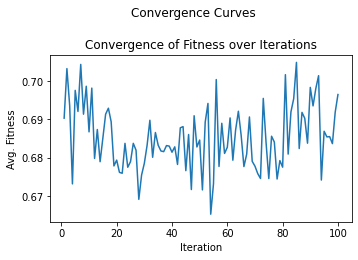

In [5]:
num_agents = 20; max_iter = 100;
solution = PSO(num_agents, max_iter, weight_acc=0.8, train_data = X_train, train_label = y_train.values.ravel())